# Bagging (회귀) 하이퍼파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.regression import *

# 최적의 성능을 보이는 모델
from sklearn.tree import DecisionTreeRegressor

# 배깅 회귀
from sklearn.ensemble import BaggingRegressor

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx", info=False)


상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX |   PTRATIO |      B |   LSTAT |   MEDV |
|----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------|
|  0 | 0.00632 |   18 |    2.31 |      0 | 0.538 | 6.575 |  65.2 |   4.09 |     1 |   296 |      15.3 |  396.9 |    4.98 |     24 |
|  1 | 0.02731 |    0 |    7.07 |      0 | 0.469 | 6.421 |  78.9 | 4.9671 |     2 |   242 |      17.8 |  396.9 |    9.14 |   21.6 |
|  2 | 0.02729 |    0 |    7.07 |      0 | 0.469 | 7.185 |  61.1 | 4.9671 |     2 |   242 |      17.8 | 392.83 |    4.03 |   34.7 |
|  3 | 0.03237 |    0 |    2.18 |      0 | 0.458 | 6.998 |  45.8 | 6.0622 |     3 |   222 |      18.7 | 394.63 |    2.94 |   33.4 |
|  4 | 0.06905 |    0 |    2.18 |      0 | 0.458 | 7.147 |  54.2 | 

### [3] 훈련/검증 데이터 분할 및 데이터 표준화

In [3]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, 'MEDV', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

## #02. 하이퍼파라미터 튜닝

### [1] 최적 성능을 보인 모형

#### (1) 모형 객체 생성

이전 예제에서 이 데이터에 대한 최적 모형은 의사결정나무 모형이었다.

In [4]:
estimator = get_estimator(classname=DecisionTreeRegressor)
estimator

DecisionTreeRegressor(random_state=0)

#### (2) 최적성능을 보인 모형에 대한 하이퍼파라미터

In [5]:
params = get_hyper_params(classname=DecisionTreeRegressor, key='estimator')
params

{'estimator__criterion': ['squared_error',
  'friedman_mse',
  'absolute_error',
  'poisson']}

### [2] Bagging 모형에 대한 하이퍼 파라미터

In [6]:
bagging_params = get_hyper_params(classname=BaggingClassifier)
bagging_params

{'bootstrap_features': [False, True],
 'n_estimators': [10, 20, 50, 100],
 'max_features': [0.5, 0.7, 1.0],
 'max_samples': [0.5, 0.7, 1.0]}

### [3] 하이퍼파라미터 결합

In [7]:
params.update(bagging_params)
params

{'estimator__criterion': ['squared_error',
  'friedman_mse',
  'absolute_error',
  'poisson'],
 'bootstrap_features': [False, True],
 'n_estimators': [10, 20, 50, 100],
 'max_features': [0.5, 0.7, 1.0],
 'max_samples': [0.5, 0.7, 1.0]}

In [8]:
rcv = RandomizedSearchCV(
    estimator=BaggingRegressor(estimator=estimator, random_state=get_random_state()), 
    param_distributions=params, 
    n_iter=get_max_iter(), 
    n_jobs=get_n_jobs(),
    random_state=get_random_state(), 
    cv=5)

rcv.fit(x_train, y_train)

result_df = DataFrame(rcv.cv_results_['params'])
result_df['mean_test_score'] = rcv.cv_results_['mean_test_score']
result_df.dropna(subset=['mean_test_score'], inplace=True)
result_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

result_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 288 is smaller than n_iter=1000. Running 288 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,n_estimators,max_samples,max_features,estimator__criterion,bootstrap_features,mean_test_score
94,50,1.0,0.7,absolute_error,False,0.871086
58,50,1.0,0.7,friedman_mse,False,0.869513
22,50,1.0,0.7,squared_error,False,0.869391
59,100,1.0,0.7,friedman_mse,False,0.868513
95,100,1.0,0.7,absolute_error,False,0.868384
...,...,...,...,...,...,...
229,20,0.5,0.7,absolute_error,True,0.806211
220,10,0.7,0.5,absolute_error,True,0.805856
252,10,0.5,0.5,poisson,True,0.805608
217,20,0.5,0.5,absolute_error,True,0.803689


[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.982841 |     0.688836 |
| 평균절대오차(MAE)             |     0.859436 |      2.94181 |
| 평균제곱오차(MSE)             |      1.46097 |      25.3376 |
| 평균오차(RMSE)                |      1.20871 |      5.03365 |
| 평균 절대 백분오차 비율(MAPE) |      4.33102 |      13.2115 |
| 평균 비율 오차(MPE)           |     -1.26135 |     -3.06619 |
+-------------------------------+--------------+--------------+

[학습곡선]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 288 is smaller than n_iter=1000. Running 288 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 288 is smaller than n_iter=1000. Running 288 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 288 is smaller than n_iter=1000. Running 288 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of paramete

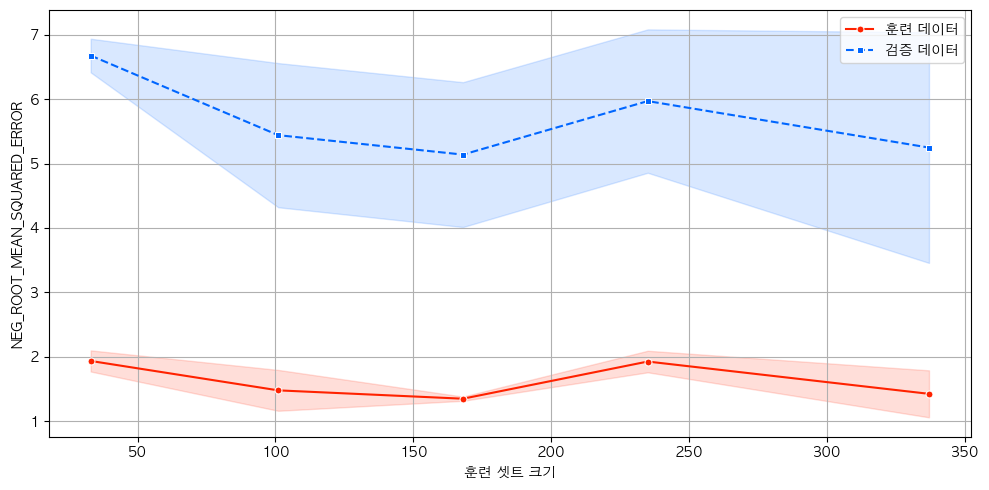

In [9]:
my_regression_result(estimator=rcv, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [10]:
my_regression_report(estimator=rcv, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV       | INDUS      |  4.9238 |
|  3 | MEDV       | CHAS       | 1.32047 |
|  4 | MEDV       | NOX        | 4.17384 |
|  5 | MEDV       | RM         | 1.82706 |
|  6 | MEDV       | AGE        | 2.93317 |
|  7 | MEDV       | DIS        | 4.41185 |
|  8 | MEDV       | RAD        | 9.98804 |
|  9 | MEDV       | TAX        | 10.5503 |
| 10 | MEDV       | PTRATIO    | 1.88398 |
| 11 | MEDV       | B          |  1.5563 |
| 12 | MEDV       | LSTAT      |  2.8052 |
+----+------------+------------+---------+



## #03. 모듈 기능 확인

분류분석과 마찬가지로 3가지 경우로 사용할 수 있음

가지치기를 하지 않습니다.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration 



==================== 모델 성능 비교 ====================
+-----------------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|                       |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|-----------------------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| SVR                   |       0.522683 |             3.75378 |             38.8672 |          6.23436 |                         17.6361 |               1.94136 |
| SGDRegressor          |       0.574904 |             3.90074 |             34.6149 |          5.88344 |                         18.6915 |              -3.94553 |
| Ridge                 |       0.579142 |             3.85534 |             34.2698 |          5.85404 |                         18.3134 |               -3.3344 |

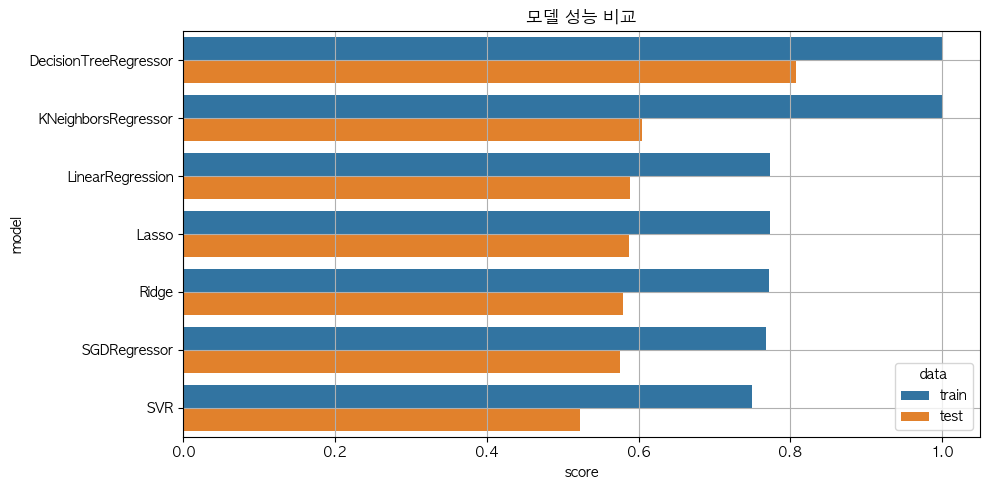

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |            1 |     0.807113 |
| 평균절대오차(MAE)             |            0 |      2.89608 |
| 평균제곱오차(MSE)             |            0 |      15.7065 |
| 평균오차(RMSE)                |            0 |      3.96314 |
| 평균 절대 백분오차 비율(MAPE) |            0 |      15.3313 |
| 평균 비율 오차(MPE)           |            0 |     -2.07076 |
+-------------------------------+--------------+--------------+

[학습곡선]


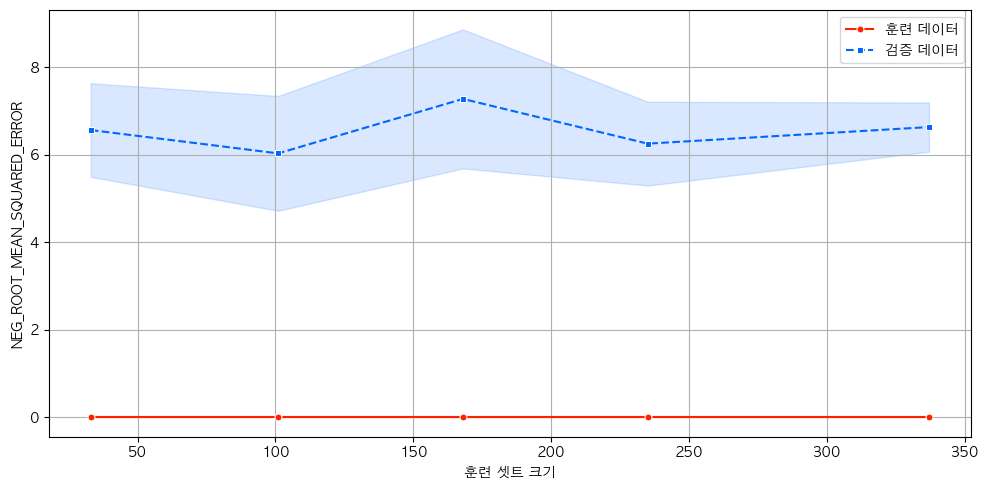

[교차검증 TOP5]
+----+----------------+---------------+----------------+----------------------+-------------------+
|    |   n_estimators |   max_samples |   max_features | bootstrap_features   |   mean_test_score |
|----+----------------+---------------+----------------+----------------------+-------------------|
|  0 |             50 |             1 |            0.7 | False                |          0.867035 |
|  1 |            100 |             1 |              1 | True                 |          0.863252 |
|  2 |             50 |             1 |              1 | False                |          0.855944 |
|  3 |            100 |             1 |            0.7 | True                 |           0.85487 |
|  4 |            100 |           0.7 |            0.5 | False                |          0.852703 |
+----+----------------+---------------+----------------+----------------------+-------------------+

[Best Params]
{'n_estimators': 50, 'max_samples': 1.0, 'max_features': 0.7, 'bootstrap_

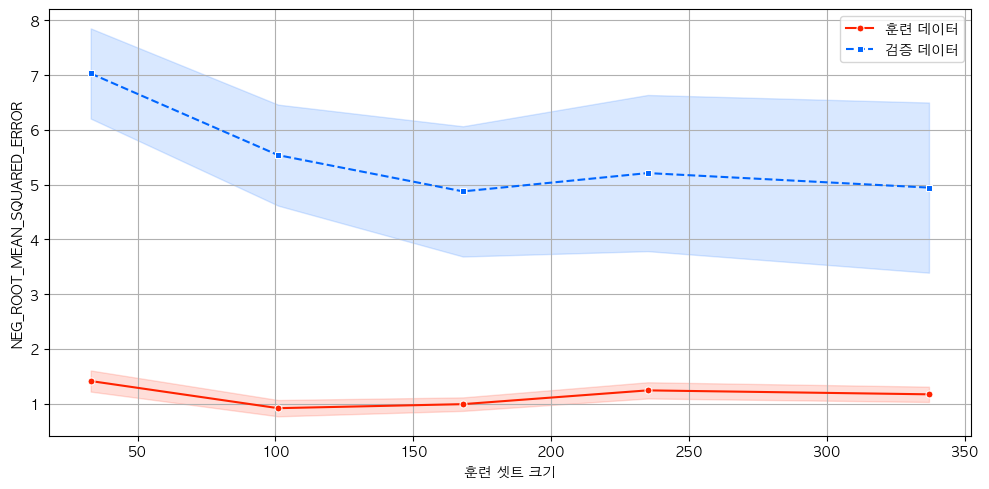


+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV       | INDUS      |  4.9238 |
|  3 | MEDV       | CHAS       | 1.32047 |
|  4 | MEDV       | NOX        | 4.17384 |
|  5 | MEDV       | RM         | 1.82706 |
|  6 | MEDV       | AGE        | 2.93317 |
|  7 | MEDV       | DIS        | 4.41185 |
|  8 | MEDV       | RAD        | 9.98804 |
|  9 | MEDV       | TAX        | 10.5503 |
| 10 | MEDV       | PTRATIO    | 1.88398 |
| 11 | MEDV       | B          |  1.5563 |
| 12 | MEDV       | LSTAT      |  2.8052 |
+----+------------+------------+---------+



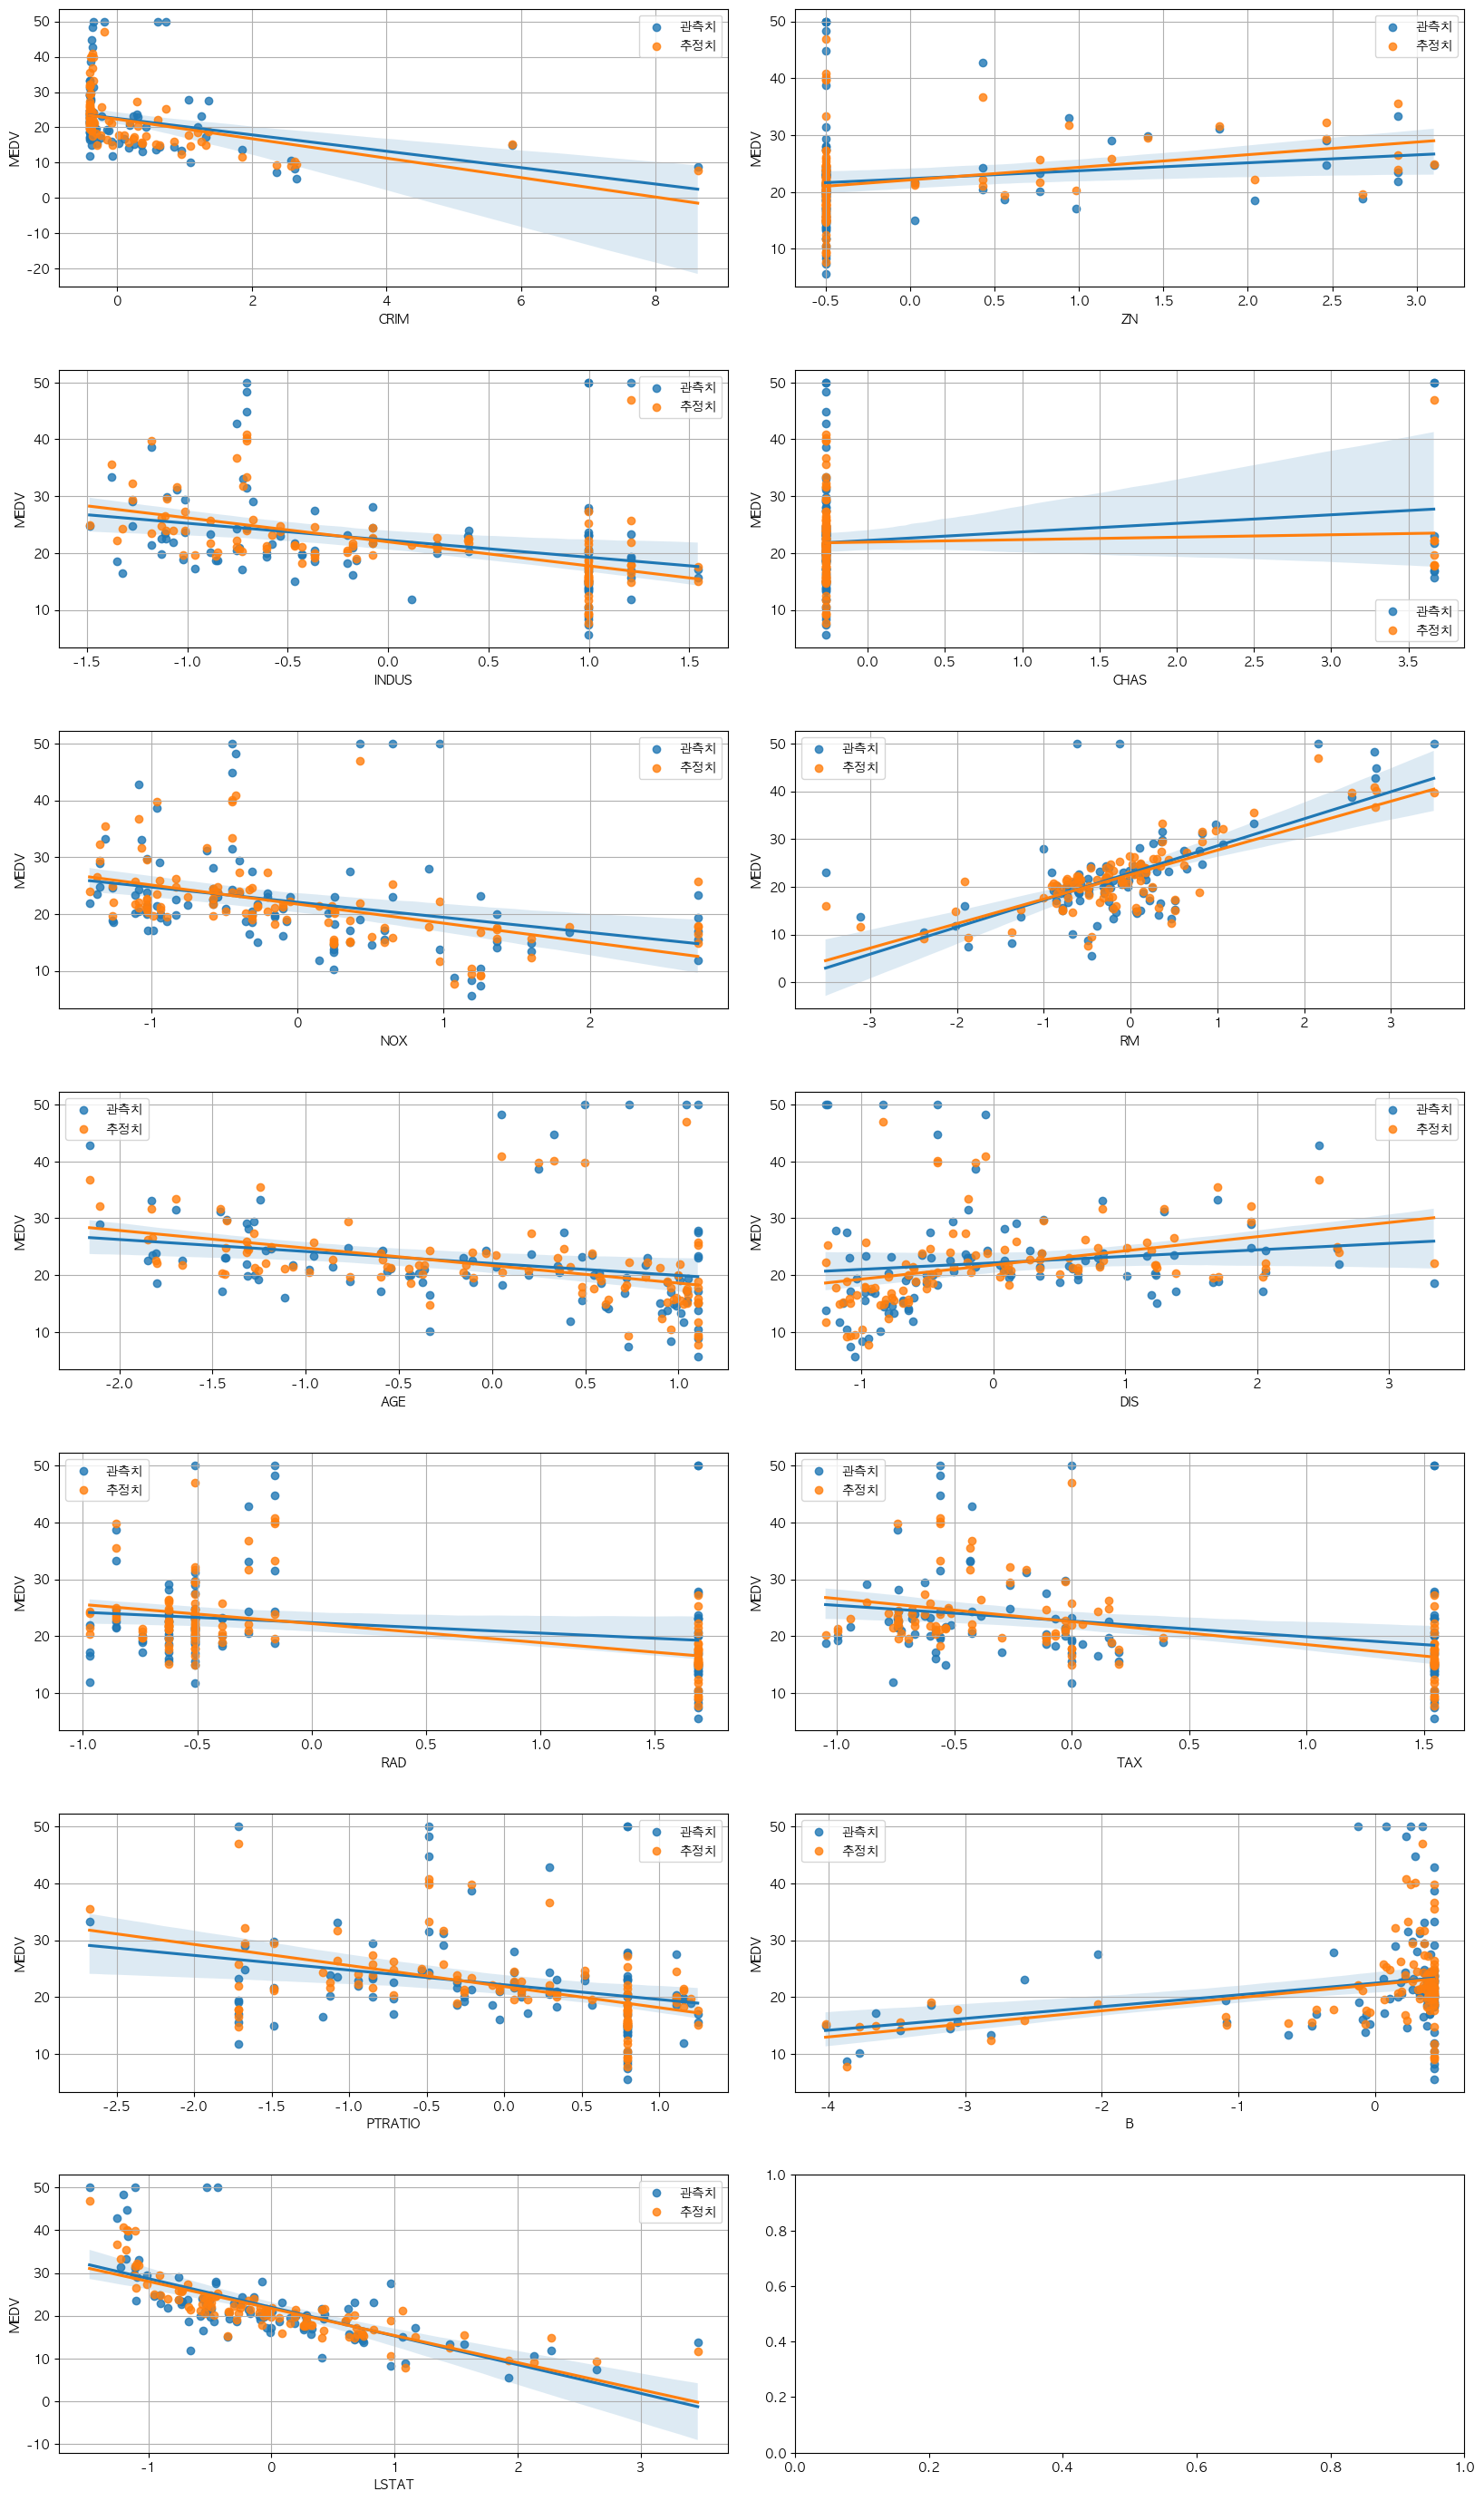

BaggingRegressor(estimator=DecisionTreeRegressor(criterion='poisson',
                                                 random_state=0),
                 max_features=0.7, n_estimators=50, n_jobs=-1, random_state=0,
                 verbose=False)

In [11]:
my_bagging_regression(x_train, y_train, x_test, y_test)